# ModernBERT Ensemble Model Training

This notebook implements an ensemble approach for hate speech detection, where each individual model is trained on a specific identity term dataset. The ensemble combines predictions using different voting mechanisms, including majority voting and weighted averaging.

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import pipeline
from checklist.pred_wrapper import PredictorWrapper
from checklist.test_types import MFT
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import dataHandler as dh

## 1. Setup Environment and Global Variables

In [2]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Base model ID for ModernBERT
model_id = "answerdotai/ModernBERT-base"

# Load the ModernBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Path to store ensemble models
ensemble_models_dir = "modernbert_ensemble"
os.makedirs(ensemble_models_dir, exist_ok=True)

Using device: cuda


## 2. Prepare Individual Datasets by Identity Term

In [6]:
# Get the list of identity terms
id_terms = dh.getListOfIdTerms()[:-1]
print(f"Identity terms to be used for individual models: {id_terms}")

# Function to tokenize dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, return_tensors="pt", max_length=140)

# Function to prepare dataset for a specific identity term
def prepare_id_term_dataset(id_term, test_size=0.2):
    print(f"Preparing dataset for identity term: {id_term}")
    
    # Get dataset for this identity term
    dataset = dh.toxigenDataset(id_term, test_size=test_size)
    
    # Rename label column to labels for compatibility with Trainer
    if "label" in dataset["train"].features.keys():
        dataset = dataset.rename_column("label", "labels")
    
    # Tokenize the dataset
    tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
    
    print(f"  Train set size: {len(tokenized_dataset['train'])} samples")
    print(f"  Test set size: {len(tokenized_dataset['test'])} samples")
    
    return tokenized_dataset

Identity terms to be used for individual models: ['asian', 'black', 'chinese', 'jewish', 'latino', 'lgbtq', 'mental_dis', 'mexican', 'middle_east', 'muslim', 'native_american', 'physical_dis', 'women']


In [6]:
# Prepare datasets for each identity term
term_datasets = {}
for term in id_terms:
    term_datasets[term] = prepare_id_term_dataset(term)

Preparing dataset for identity term: asian


Map:   0%|          | 0/15907 [00:00<?, ? examples/s]

Map:   0%|          | 0/3977 [00:00<?, ? examples/s]

  Train set size: 15907 samples
  Test set size: 3977 samples
Preparing dataset for identity term: black


Map:   0%|          | 0/15902 [00:00<?, ? examples/s]

Map:   0%|          | 0/3976 [00:00<?, ? examples/s]

  Train set size: 15902 samples
  Test set size: 3976 samples
Preparing dataset for identity term: chinese


Map:   0%|          | 0/15247 [00:00<?, ? examples/s]

Map:   0%|          | 0/3812 [00:00<?, ? examples/s]

  Train set size: 15247 samples
  Test set size: 3812 samples
Preparing dataset for identity term: jewish


Map:   0%|          | 0/15634 [00:00<?, ? examples/s]

Map:   0%|          | 0/3908 [00:00<?, ? examples/s]

  Train set size: 15634 samples
  Test set size: 3908 samples
Preparing dataset for identity term: latino


Map:   0%|          | 0/14836 [00:00<?, ? examples/s]

Map:   0%|          | 0/3709 [00:00<?, ? examples/s]

  Train set size: 14836 samples
  Test set size: 3709 samples
Preparing dataset for identity term: lgbtq


Map:   0%|          | 0/16756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4189 [00:00<?, ? examples/s]

  Train set size: 16756 samples
  Test set size: 4189 samples
Preparing dataset for identity term: mental_dis


Map:   0%|          | 0/14927 [00:00<?, ? examples/s]

Map:   0%|          | 0/3732 [00:00<?, ? examples/s]

  Train set size: 14927 samples
  Test set size: 3732 samples
Preparing dataset for identity term: mexican


Map:   0%|          | 0/16283 [00:00<?, ? examples/s]

Map:   0%|          | 0/4070 [00:00<?, ? examples/s]

  Train set size: 16283 samples
  Test set size: 4070 samples
Preparing dataset for identity term: middle_east


Map:   0%|          | 0/16237 [00:00<?, ? examples/s]

Map:   0%|          | 0/4060 [00:00<?, ? examples/s]

  Train set size: 16237 samples
  Test set size: 4060 samples
Preparing dataset for identity term: muslim


Map:   0%|          | 0/15884 [00:00<?, ? examples/s]

Map:   0%|          | 0/3971 [00:00<?, ? examples/s]

  Train set size: 15884 samples
  Test set size: 3971 samples
Preparing dataset for identity term: native_american


Map:   0%|          | 0/15488 [00:00<?, ? examples/s]

Map:   0%|          | 0/3872 [00:00<?, ? examples/s]

  Train set size: 15488 samples
  Test set size: 3872 samples
Preparing dataset for identity term: physical_dis


Map:   0%|          | 0/12399 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

  Train set size: 12399 samples
  Test set size: 3100 samples
Preparing dataset for identity term: women


Map:   0%|          | 0/15260 [00:00<?, ? examples/s]

Map:   0%|          | 0/3815 [00:00<?, ? examples/s]

  Train set size: 15260 samples
  Test set size: 3815 samples


## 3. Define Model Training Functions

In [7]:
# Metric helper method
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    probs = torch.nn.functional.softmax(torch.tensor(eval_pred.predictions), dim=-1)

    try:
        f1 = f1_score(labels, predictions, average="weighted")
        aucroc = roc_auc_score(labels, probs[:, 1].numpy())
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        f1 = 0.0
        aucroc = 0.5
    
    return {
        "f1": f1,
        "aucroc": aucroc
    }

# Prepare model labels
labels = ["no hate", "hate"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Function to create a model
def create_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id, num_labels=num_labels, label2id=label2id, id2label=id2label
    )
    return model

# Function to train a model for a specific identity term
def train_model_for_term(term, tokenized_dataset, epochs=3):
    print(f"\nTraining model for identity term: {term}...")
    
    model = create_model()
    model.to(device)
    
    output_dir = f"{ensemble_models_dir}/{term}-model"
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        learning_rate=2e-5,
        num_train_epochs=epochs,
        warmup_ratio=0.1,
        weight_decay=0.01,
        bf16=torch.cuda.is_available(),
        fp16=not torch.cuda.is_available() and hasattr(torch, 'has_mps'),
        optim="adamw_torch_fused" if torch.cuda.is_available() else "adamw_torch",
        logging_strategy="steps",
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        gradient_accumulation_steps=2,
        report_to="tensorboard",
        lr_scheduler_type="cosine",
        seed=42
    )
    
    # Early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.001
    )
    
    # Create a Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )
    
    # Train the model
    trainer.train()
    
    # Save the model and tokenizer
    model_path = f"{ensemble_models_dir}/{term}-final"
    tokenizer_path = f"{ensemble_models_dir}/{term}-tokenizer"
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)
    
    print(f"Model for {term} saved to {model_path}")
    
    return {
        "model_path": model_path,
        "tokenizer_path": tokenizer_path
    }

## 4. Train Individual Models for Each Identity Term

In [8]:
# Train models for each identity term
trained_models = {}

for term in id_terms:
    trained_models[term] = train_model_for_term(term, term_datasets[term])


Training model for identity term: asian...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.748500,0.360530,0.829420,0.903263
200,0.544700,0.283449,0.873079,0.939844
300,0.522200,0.258208,0.886346,0.948953
400,0.456100,0.246797,0.899618,0.956256
500,0.461700,0.260436,0.882647,0.959715
600,0.289900,0.243214,0.905300,0.963654
700,0.316600,0.221916,0.906664,0.965240
800,0.346600,0.239119,0.907871,0.967012
900,0.313900,0.216654,0.916760,0.968908
1000,0.262500,0.227710,0.914855,0.968106


Model for asian saved to modernbert_ensemble/asian-final

Training model for identity term: black...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.784600,0.392759,0.832020,0.907766
200,0.581800,0.305620,0.870873,0.938561
300,0.565200,0.262362,0.885369,0.950068
400,0.498200,0.254413,0.881188,0.956481
500,0.425100,0.236011,0.898421,0.959694
600,0.288200,0.242714,0.911921,0.964246
700,0.329400,0.284407,0.898137,0.963483
800,0.249000,0.270655,0.904496,0.964222
900,0.278000,0.238162,0.906887,0.965577


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model for black saved to modernbert_ensemble/black-final

Training model for identity term: chinese...


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.796100,0.353649,0.826581,0.897232
200,0.640700,0.272257,0.878534,0.936988
300,0.578800,0.273773,0.881426,0.941978
400,0.489700,0.255119,0.888707,0.953426
500,0.377000,0.248222,0.902269,0.956497
600,0.283200,0.300485,0.901374,0.956845
700,0.288100,0.254805,0.906638,0.957403
800,0.261200,0.258502,0.901418,0.957740
900,0.261500,0.254184,0.902539,0.961100
1000,0.124400,0.310694,0.900519,0.960356


Model for chinese saved to modernbert_ensemble/chinese-final

Training model for identity term: jewish...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.782200,0.376113,0.828628,0.907312
200,0.601800,0.310864,0.857786,0.930356
300,0.577900,0.268348,0.881691,0.948171
400,0.568900,0.279997,0.873532,0.953619
500,0.462700,0.239325,0.900823,0.960779
600,0.306200,0.269239,0.905391,0.962739
700,0.323600,0.251495,0.909612,0.962942
800,0.319000,0.245753,0.907775,0.964442
900,0.299100,0.235418,0.907975,0.965669
1000,0.223900,0.252167,0.912773,0.966637


Model for jewish saved to modernbert_ensemble/jewish-final

Training model for identity term: latino...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.955700,0.453394,0.783988,0.842885
200,0.787400,0.378718,0.824537,0.891834
300,0.664900,0.317540,0.856186,0.929023
400,0.613300,0.297809,0.866673,0.938939
500,0.501900,0.309710,0.869989,0.942941
600,0.418500,0.316682,0.868720,0.945628
700,0.405800,0.294124,0.874513,0.945927
800,0.373500,0.294875,0.880993,0.950541
900,0.365300,0.304158,0.883540,0.948855
1000,0.153700,0.333674,0.886963,0.951296


Model for latino saved to modernbert_ensemble/latino-final

Training model for identity term: lgbtq...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.833400,0.354124,0.829564,0.875153
200,0.638300,0.282652,0.867586,0.923743
300,0.570700,0.240785,0.894002,0.945462
400,0.503700,0.225661,0.891454,0.954173
500,0.448200,0.198382,0.910695,0.963319
600,0.323200,0.214983,0.908560,0.962696
700,0.310800,0.205544,0.917840,0.963757
800,0.319300,0.200902,0.916844,0.964843
900,0.290100,0.198634,0.918881,0.966767
1000,0.269400,0.202878,0.919308,0.968384


Model for lgbtq saved to modernbert_ensemble/lgbtq-final

Training model for identity term: mental_dis...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.774000,0.339313,0.824712,0.897034
200,0.587000,0.274191,0.881040,0.948359
300,0.438100,0.210305,0.911020,0.959729
400,0.373300,0.183355,0.921489,0.968740
500,0.300300,0.192486,0.926170,0.969464
600,0.253100,0.176522,0.928409,0.972778
700,0.313300,0.219939,0.921897,0.975019
800,0.261300,0.173381,0.933857,0.975842
900,0.287000,0.165461,0.933690,0.977743
1000,0.102500,0.210529,0.935265,0.978019


Model for mental_dis saved to modernbert_ensemble/mental_dis-final

Training model for identity term: mexican...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.829500,0.344116,0.841378,0.907766
200,0.573400,0.258384,0.885654,0.950419
300,0.539100,0.221546,0.903516,0.963544
400,0.484600,0.212362,0.909198,0.967116
500,0.464700,0.198205,0.910791,0.970956
600,0.316800,0.234145,0.903731,0.970317
700,0.341600,0.198201,0.914198,0.971757
800,0.259200,0.207903,0.914246,0.973513
900,0.268300,0.198826,0.923117,0.974905
1000,0.251700,0.207200,0.921637,0.975142


Model for mexican saved to modernbert_ensemble/mexican-final

Training model for identity term: middle_east...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.852400,0.351669,0.843587,0.907243
200,0.554700,0.309169,0.871942,0.946140
300,0.499600,0.223414,0.902988,0.964020
400,0.430000,0.211320,0.911462,0.967734
500,0.376000,0.222270,0.909022,0.968763
600,0.238800,0.301918,0.910806,0.972405
700,0.282400,0.281456,0.899034,0.969521


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model for middle_east saved to modernbert_ensemble/middle_east-final

Training model for identity term: muslim...


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.844700,0.374081,0.829848,0.881170
200,0.652400,0.343830,0.823962,0.924915
300,0.614900,0.294128,0.863878,0.939667
400,0.499000,0.256620,0.889929,0.951434
500,0.466700,0.257104,0.894156,0.956152
600,0.334000,0.246879,0.897983,0.958667
700,0.330100,0.246788,0.906037,0.958303
800,0.290300,0.246478,0.907700,0.960910
900,0.323700,0.229772,0.909917,0.962998
1000,0.298700,0.221302,0.913310,0.963829


Model for muslim saved to modernbert_ensemble/muslim-final

Training model for identity term: native_american...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.688900,0.340663,0.837903,0.899874
200,0.591200,0.283450,0.871720,0.927527
300,0.479300,0.264171,0.885599,0.941960
400,0.450400,0.232200,0.900126,0.957327
500,0.416600,0.225138,0.906350,0.959433
600,0.284800,0.228598,0.913555,0.963511
700,0.273700,0.225951,0.911514,0.965068
800,0.263600,0.225841,0.907234,0.962385
900,0.249500,0.232936,0.912682,0.962510


Model for native_american saved to modernbert_ensemble/native_american-final

Training model for identity term: physical_dis...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.782800,0.361877,0.834972,0.886636
200,0.583500,0.297338,0.861503,0.924388
300,0.522100,0.261884,0.874064,0.945516
400,0.467100,0.250853,0.889715,0.944341
500,0.323000,0.256659,0.898656,0.949949
600,0.309000,0.234941,0.909018,0.955877
700,0.323600,0.236033,0.900559,0.955280
800,0.205100,0.286936,0.902273,0.955214
900,0.126800,0.352116,0.904044,0.957650


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model for physical_dis saved to modernbert_ensemble/physical_dis-final

Training model for identity term: women...


Step,Training Loss,Validation Loss,F1,Aucroc
100,0.742500,0.333383,0.826191,0.894307
200,0.604100,0.281480,0.870887,0.922107
300,0.490300,0.242690,0.888025,0.943718
400,0.518800,0.219708,0.902295,0.954889
500,0.430100,0.252338,0.889137,0.953958
600,0.268100,0.241357,0.909513,0.958211
700,0.339100,0.217408,0.908229,0.958620
800,0.266000,0.236327,0.906326,0.956318
900,0.322000,0.230242,0.908193,0.958171


Model for women saved to modernbert_ensemble/women-final


## 5. Ensemble Methods Implementation

In [3]:
class EnsembleClassifier:
    def __init__(self, model_paths, voting="majority", weights=None):
        """
        Initialize the ensemble classifier.
        
        Parameters:
        - model_paths: Dictionary mapping term names to dictionaries with 'model_path' and 'tokenizer_path'
        - voting: String, voting mechanism to use ('majority', 'weighted_average')
        - weights: Optional dictionary mapping term names to weights for weighted averaging
        """
        self.model_paths = model_paths
        self.voting = voting
        self.models = {}
        self.tokenizers = {}
        self.pipelines = {}
        self.term_names = list(model_paths.keys())
        
        # Default to equal weights if none provided
        if weights is None:
            self.weights = {term: 1.0/len(model_paths) for term in model_paths.keys()}
        else:
            self.weights = weights
            # Normalize weights to sum to 1
            weight_sum = sum(self.weights.values())
            self.weights = {k: v/weight_sum for k, v in self.weights.items()}
        
        # Load models and tokenizers
        for term, paths in model_paths.items():
            print(f"Loading model for {term}...")
            self.tokenizers[term] = AutoTokenizer.from_pretrained(paths['tokenizer_path'])
            self.models[term] = AutoModelForSequenceClassification.from_pretrained(paths['model_path'])
            self.models[term].to(device)
            
            # Create pipeline
            self.pipelines[term] = pipeline(
                task="text-classification",
                tokenizer=self.tokenizers[term],
                model=self.models[term],
                device=0 if torch.cuda.is_available() else -1
            )
    
    def predict(self, texts):
        """
        Make predictions using the ensemble.
        
        Parameters:
        - texts: List of strings, texts to classify
        
        Returns:
        - predictions: List of prediction labels
        - confidences: List of confidence scores
        """
        if not isinstance(texts, list):
            texts = [texts]
        
        # Determine batch size based on available memory
        batch_size = 32
        
        # Process in batches for better performance
        all_model_scores = {term: [] for term in self.term_names}
        
        # Process each term's model in batches
        for term in self.term_names:
            model = self.models[term]
            tokenizer = self.tokenizers[term]
            
            model_scores = []
            
            # Process texts in batches
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                
                # Tokenize
                inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=140)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # Get predictions
                with torch.no_grad():
                    outputs = model(**inputs)
                    logits = outputs.logits
                    probs = torch.nn.functional.softmax(logits, dim=1)
                    
                    # Get probability of hate class (index 1)
                    hate_probs = probs[:, 1].cpu().numpy()
                    model_scores.extend(hate_probs)
            
            all_model_scores[term] = np.array(model_scores)
        
        # Apply ensemble method
        final_predictions = []
        final_confidences = []
        
        # Convert to numpy arrays for vectorized operations
        model_scores_array = np.array([all_model_scores[term] for term in self.term_names])
        
        if self.voting == "majority":
            # Convert scores to binary predictions (1 for hate, 0 for no hate)
            binary_preds = (model_scores_array >= 0.5).astype(int)
            
            # Sum across models (axis 0) to get votes for each text
            vote_counts = np.sum(binary_preds, axis=0)
            
            # Majority rule
            hate_predictions = vote_counts > (len(self.term_names) / 2)
            
            # Calculate confidence as proportion of votes
            confidences = np.maximum(vote_counts, len(self.term_names) - vote_counts) / len(self.term_names)
            
            # Convert to strings and list
            final_predictions = ["hate" if pred else "no hate" for pred in hate_predictions]
            final_confidences = confidences.tolist()
            
        elif self.voting == "weighted_average":
            # Apply weights to each model's predictions
            weights_array = np.array([self.weights[term] for term in self.term_names])
            
            # Weighted sum of scores (weights_array[:, np.newaxis] broadcasts weights across all samples)
            weighted_scores = np.sum(model_scores_array * weights_array[:, np.newaxis], axis=0)
            
            # Classify based on threshold
            hate_predictions = weighted_scores >= 0.5
            
            # Confidence is max of score or 1-score
            confidences = np.maximum(weighted_scores, 1 - weighted_scores)
            
            # Convert to strings and list
            final_predictions = ["hate" if pred else "no hate" for pred in hate_predictions]
            final_confidences = confidences.tolist()
        
        return final_predictions, final_confidences

In [4]:
# CheckList wrapper for the ensemble classifier
class EnsembleClassifierWrapper(PredictorWrapper):
    def __init__(self, ensemble_classifier):
        self.ensemble = ensemble_classifier
        
    def __call__(self, texts):
        predictions, confidences = self.ensemble.predict(texts)
        return predictions, confidences

## 6. Load or Create the Ensemble Model

In [7]:
# Check if models are already trained and available
def load_trained_models():
    trained_models = {}
    for term in id_terms:
        model_path = f"{ensemble_models_dir}/{term}-final"
        tokenizer_path = f"{ensemble_models_dir}/{term}-tokenizer"
        
        if os.path.exists(model_path) and os.path.exists(tokenizer_path):
            trained_models[term] = {
                "model_path": model_path,
                "tokenizer_path": tokenizer_path
            }
            print(f"Found existing model for {term}")
    
    return trained_models

# Try to load existing models first
loaded_models = load_trained_models()
print(f"Loaded {len(loaded_models)} existing models")

# If we have models for all terms, use them
if len(loaded_models) == len(id_terms):
    trained_models = loaded_models
    print("Using pre-trained models for all identity terms")
else:
    # Train models that are missing
    missing_terms = set(id_terms) - set(loaded_models.keys())
    for term in missing_terms:
        print(f"Training model for {term} as it was not found")
        term_model_info = train_model_for_term(term, term_datasets[term])
        loaded_models[term] = term_model_info
    
    trained_models = loaded_models

Found existing model for asian
Found existing model for black
Found existing model for chinese
Found existing model for jewish
Found existing model for latino
Found existing model for lgbtq
Found existing model for mental_dis
Found existing model for mexican
Found existing model for middle_east
Found existing model for muslim
Found existing model for native_american
Found existing model for physical_dis
Found existing model for women
Loaded 13 existing models
Using pre-trained models for all identity terms


## 7. Evaluate Models on Test Data

In [8]:
# Get annotated Russian test dataset
test_dict = dh.getAnnotadedRussTest()
print(f"Loaded test data with {len(test_dict['text'])} samples")

Loaded test data with 996 samples


In [9]:
# Create and evaluate majority voting ensemble
majority_ensemble = EnsembleClassifier(trained_models, voting="majority")
majority_wrapper = EnsembleClassifierWrapper(majority_ensemble)

hate_test_majority = MFT(data=test_dict['text'], labels=test_dict['label'], name="Ensemble Majority Voting Test")
majority_results = hate_test_majority.run(majority_wrapper, overwrite=True)
hate_test_majority.summary()

Loading model for asian...


Device set to use cuda:0


Loading model for black...


Device set to use cuda:0


Loading model for chinese...


Device set to use cuda:0


Loading model for jewish...


Device set to use cuda:0


Loading model for latino...


Device set to use cuda:0


Loading model for lgbtq...


Device set to use cuda:0


Loading model for mental_dis...


Device set to use cuda:0


Loading model for mexican...


Device set to use cuda:0


Loading model for middle_east...


Device set to use cuda:0


Loading model for muslim...


Device set to use cuda:0


Loading model for native_american...


Device set to use cuda:0


Loading model for physical_dis...


Device set to use cuda:0


Loading model for women...


Device set to use cuda:0


Predicting 996 examples
Test cases:      996
Fails (rate):    292 (29.3%)

Example fails:
hate                                                  not to the stupid city boy, to him there is no evidence.
----
hate russia wants ‘revenge’ – sydney — rt russia &amp; former soviet union  correcting the historical wrong and making the criminals pay is called justice, not revenge. but the twat doesn't know better.
----
hate  i think starting world war over ukraine is stupid
----
Test cases:      996
Fails (rate):    292 (29.3%)

Example fails:
hate                                                  not to the stupid city boy, to him there is no evidence.
----
hate russia wants ‘revenge’ – sydney — rt russia &amp; former soviet union  correcting the historical wrong and making the criminals pay is called justice, not revenge. but the twat doesn't know better.
----
hate  i think starting world war over ukraine is stupid
----


## 10. Save the Best Ensemble Configuration

In [ ]:
# Save the optimized weights
import json

# Save weights and model paths for later use
ensemble_config = {
    "optimized_weights": best_weights,
    "models": {term: {
        "model_path": info["model_path"],
        "tokenizer_path": info["tokenizer_path"]
    } for term, info in trained_models.items()}
}

with open(f"{ensemble_models_dir}/ensemble_config.json", "w") as f:
    json.dump(ensemble_config, f, indent=2)

print(f"Ensemble configuration saved to {ensemble_models_dir}/ensemble_config.json")

In [ ]:
# Functions for using the saved ensemble in other notebooks
def load_ensemble(config_path=None, voting="weighted_average"):
    """
    Load the ensemble from a saved configuration file.
    
    Parameters:
    - config_path: Path to the ensemble configuration file. Defaults to ensemble_models_dir/ensemble_config.json
    - voting: Which voting method to use ('majority', 'weighted_average')
    
    Returns:
    - An initialized EnsembleClassifier
    """
    if config_path is None:
        config_path = f"{ensemble_models_dir}/ensemble_config.json"
    
    with open(config_path, "r") as f:
        config = json.load(f)
    
    return EnsembleClassifier(
        config["models"],
        voting=voting,
        weights=config["optimized_weights"]
    )

# Example usage:
# ensemble = load_ensemble()
# predictions, confidences = ensemble.predict(["This is a test sentence."])

## 11. Plot Confusion Matrices for Ensemble Models

In [13]:
# Function to plot confusion matrices for the ensemble models
def plot_confusion_matrix(ensemble, test_dict, ensemble_name):
    wrapper = EnsembleClassifierWrapper(ensemble)
    
    predictions, confidences = wrapper(test_dict['text'])
    
    # Convert string predictions and true labels to binary
    pred_binary = [1 if p == 'hate' else 0 for p in predictions]
    true_binary = [1 if l == 'hate' else 0 for l in test_dict['label']]
    
    # Calculate confusion matrix
    cm = confusion_matrix(true_binary, pred_binary)
    
    # Add percentages to confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['No Hate', 'Hate'], yticklabels=['No Hate', 'Hate'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix - {ensemble_name}')
    plt.savefig(f"{ensemble_models_dir}/{ensemble_name.replace(' ', '_').lower()}_confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    balanced_acc = (recall + tn/(tn+fp))/2 if (tn+fp) > 0 else recall
    
    # Calculate AUC-ROC
    try:
        aucroc = roc_auc_score(true_binary, confidences)
    except:
        aucroc = 0.5
    
    print(f"Metrics for {ensemble_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  AUC-ROC: {aucroc:.4f}")
    
    return cm

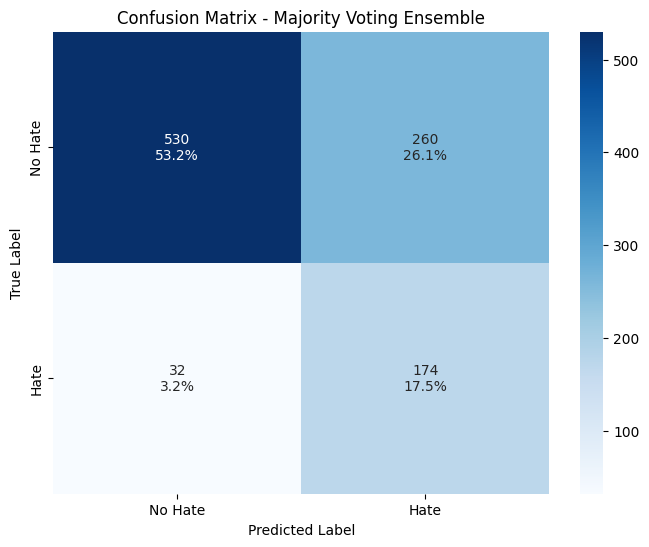

Metrics for Majority Voting Ensemble:
  Accuracy: 0.7068
  Balanced Accuracy: 0.7578
  Precision: 0.4009
  Recall: 0.8447
  F1 Score: 0.5437
  AUC-ROC: 0.4530


In [14]:
# Plot confusion matrix for majority voting ensemble
majority_cm = plot_confusion_matrix(majority_ensemble, test_dict, "Majority Voting Ensemble")